In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sklearn.model_selection

In [3]:
import pretrained_microscopy_models as pmm
import segmentation_models_pytorch as smp

In [14]:
from train import get_model, get_training_augmentation, get_preprocessing
from data import get_dataset

In [15]:
dataset = get_dataset()

images = list(map(lambda f: f[0], dataset))
images = list(map(lambda f: str(f), images))
masks = list(map(lambda f: f[1], dataset))
masks = list(map(lambda f: str(f), masks))


classes = {
    'swelling': [255,255,255]
}

images_train, images_val, masks_train, masks_val = sklearn.model_selection.train_test_split(images, masks, test_size=0.3)

In [16]:
architecture = 'UnetPlusPlus'
encoder = 'resnet50'
pretrained_weights = 'micronet'

model = get_model(architecture, encoder, pretrained_weights)

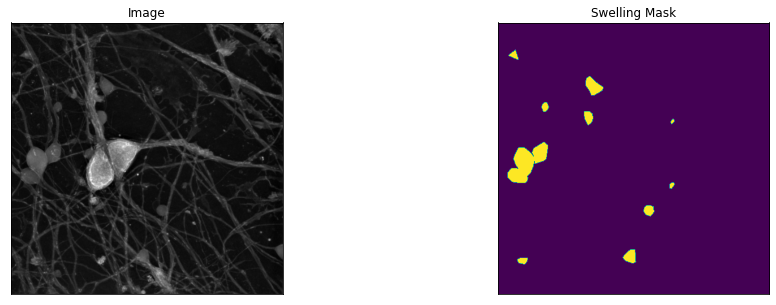

In [28]:
# Visualize Dataset:
ds_vis = pmm.io.Dataset(
    images=images,
    masks=masks,
    class_values=classes
)

for im, mask in ds_vis:
    pmm.util.visualize(
        image=im,
        swelling_mask=mask[...,0].squeeze(),
    )
    break

In [41]:
fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet') 

ds_train = pmm.io.Dataset(
    images=images_train,
    masks=masks_train,
    class_values=classes,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(fn)
)
ds_val = pmm.io.Dataset(
    images=images_val,
    masks=masks_val,
    class_values=classes,
    preprocessing=get_preprocessing(fn)
)

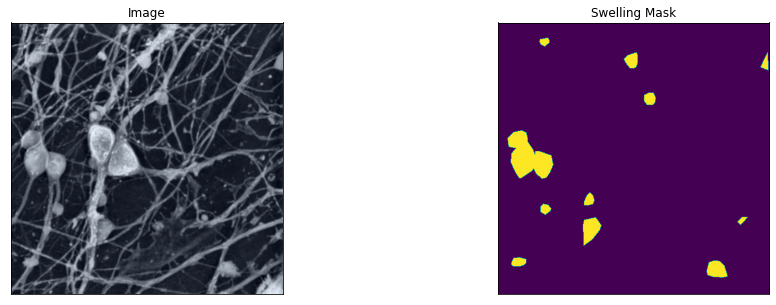

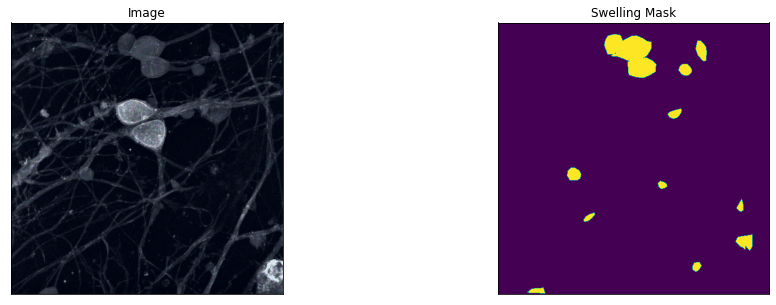

In [105]:
# Visualize Augmentations:
COUNT = 5
import matplotlib.pyplot as plt
for idx, (im, mask) in enumerate(ds_train):
    im_std = (im - im.min())
    im_std = im_std / im_std.max()
    im_std = im_std.transpose(1,2,0)
    pmm.util.visualize(
        image=im_std,
        swelling_mask=mask.squeeze(),
    )
    if idx == COUNT:
        break

In [106]:
state = pmm.segmentation_training.train_segmentation_model(
    model=model,
    architecture=architecture,
    encoder=encoder,
    train_dataset=ds_train,
    validation_dataset=ds_val,
    class_values=[255,255,255],
    patience=30,
    lr=2e-4,
    batch_size=6,
    val_batch_size=6,
    save_folder='output_models',
    save_name='UnetPlusPlus_resnet50_high_lr.pth.tar'
)


Epoch: 0, lr: 0.00020000, time: 0.00 seconds, patience step: 0, best iou: 0.0000
train: 100%|█| 1/1 [00:00<00:00,  2.93it/s, DiceBCELoss - 0.9683, iou_score

/home/ubuntu/.local/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



valid: 100%|█| 1/1 [00:00<00:00, 10.29it/s, DiceBCELoss - 1.001, iou_score 
Best model saved!

Epoch: 1, lr: 0.00020000, time: 5.21 seconds, patience step: 0, best iou: 0.0115
train: 100%|█| 1/1 [00:00<00:00,  3.27it/s, DiceBCELoss - 0.9483, iou_score
valid: 100%|█| 1/1 [00:00<00:00, 10.14it/s, DiceBCELoss - 0.9797, iou_score

Epoch: 2, lr: 0.00020000, time: 2.60 seconds, patience step: 1, best iou: 0.0115
train: 100%|█| 1/1 [00:00<00:00,  3.29it/s, DiceBCELoss - 0.9321, iou_score
valid: 100%|█| 1/1 [00:00<00:00, 10.25it/s, DiceBCELoss - 0.976, iou_score 
Best model saved!

Epoch: 3, lr: 0.00020000, time: 4.79 seconds, patience step: 0, best iou: 0.0126
train: 100%|█| 1/1 [00:00<00:00,  3.08it/s, DiceBCELoss - 0.924, iou_score 
valid: 100%|█| 1/1 [00:00<00:00, 10.39it/s, DiceBCELoss - 0.9703, iou_score
Best model saved!

Epoch: 4, lr: 0.00020000, time: 5.26 seconds, patience step: 0, best iou: 0.0154
train: 100%|█| 1/1 [00:00<00:00,  3.72it/s, DiceBCELoss - 0.9173, iou_score
valid: 10

# Run prediction (on dataset)

In [178]:
# load best model
from pathlib import Path
import torch
device=torch.device("cuda")
best_model_path = Path('output_models', 'model_best.pth.tar')
state = torch.load(best_model_path) 
best_model = pmm.segmentation_training.create_segmentation_model(
    architecture=architecture,
    encoder = encoder,
    encoder_weights=pretrained_weights, # use encoder pre-trained on micronet
    classes=1 
    )
best_model.load_state_dict(pmm.util.remove_module_from_state_dict(state['state_dict']))
best_model.cuda()

n=0
image_vis = ds_val[n][0].astype('uint8')
image, gt_mask = ds_val[n]

gt_mask = gt_mask[0].squeeze()

x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy() > .3)

pr_mask_background = pr_mask[0].squeeze()

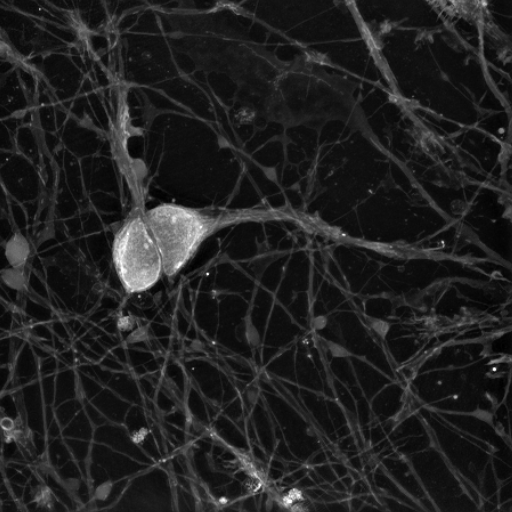

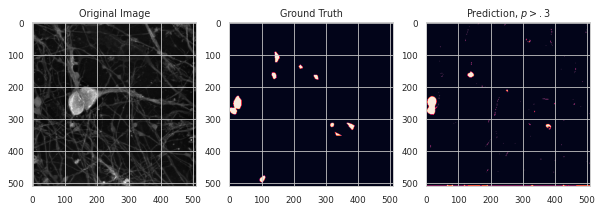

In [181]:
import matplotlib.pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(10,10))

ax2.imshow(pr_mask)
ax2.set_title("Prediction, $p > .3$")
ax1.imshow(gt_mask)
ax1.set_title("Ground Truth")
ax0.imshow(Image.open(images_val[0]))
ax0.set_title("Original Image")

plt.savefig('output_figures/example_image_gt_pred.pdf')

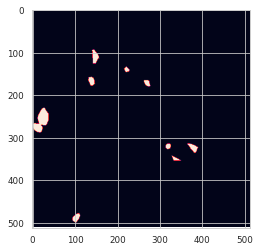

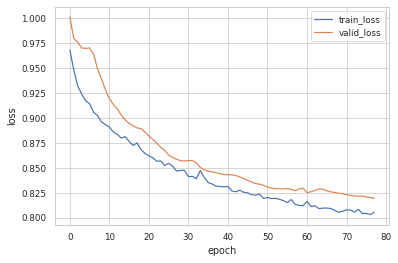

In [180]:
# Plot losses (->report)
import seaborn as sns
sns.set_theme(style="whitegrid", context="paper")
plt.plot(state['train_loss'], label='train_loss')
plt.plot(state['valid_loss'], label='valid_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig("output_figures/train_loss.pdf")

# Predict from scratch

In [111]:
from PIL import Image
import numpy as np
from pathlib import Path
import torch
best_model_path = Path('output_models', 'model_best.pth.tar')
model, preprocessing_fn = pmm.segmentation_training.load_segmentation_model(best_model_path, classes=1)

test_im_path = 'output_split/iCN-CO-22_2.1_50nm_27-OHC_20211023_60h_10min_tiff_analysis_210.tif'
test_im_path = 'output_split/CN-CO-53_Nocodazol_20220821_19.tif'

test_im = Image.open(test_im_path)
test_im_arr = np.array(test_im)

In [112]:
import imageio
import cv2
test_im_arr = imageio.imread(test_im_path)
test_im_arr = cv2.resize(test_im_arr, (512,512))

/tmp/ipykernel_11660/1849582786.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test_im_arr = imageio.imread(test_im_path)


In [114]:
t.size()

torch.Size([1, 3, 512, 512])

In [115]:
res = model(t.cuda())

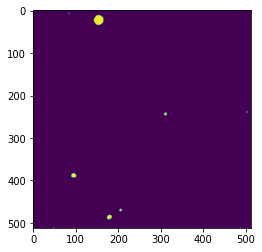

In [131]:
res_np = res.squeeze().cpu().detach().numpy()
plt.imshow(res_np > 0.5)

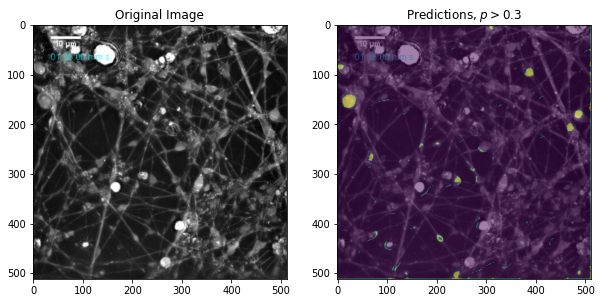

In [145]:
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,10))
ax0.imshow(test_im_arr)
ax1.imshow(test_im_arr, alpha=1)
ax1.imshow(res.squeeze().cpu().detach().numpy().transpose() > .3, alpha=0.5)
ax0.set_title("Original Image")
ax1.set_title("Predictions, $p>0.3$")
plt.savefig("output_figures/segmentation_unseen_data.pdf")